<a href="https://colab.research.google.com/github/HadeerArafa/ResNet50_SubClassing/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow
import h5py


%matplotlib inline

<a name='3'></a>
## 3 - Building a Residual Network

In ResNets, a "shortcut" or a "skip connection" allows the model to skip layers:  

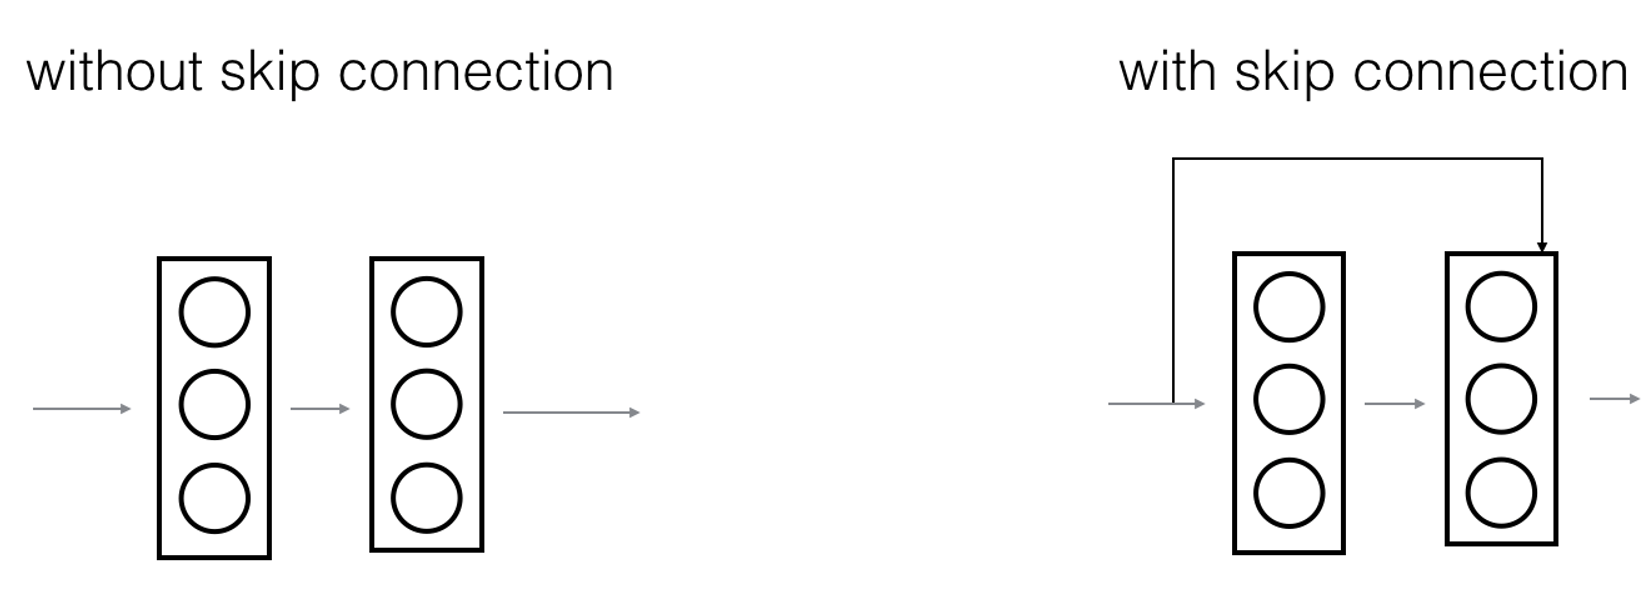
<caption><center> <u> <font color='purple'> <b>Figure 2</b> </u><font color='purple'>  : A ResNet block showing a skip-connection <br> </center></caption>

The image on the left shows the "main path" through the network. The image on the right adds a shortcut to the main path. By stacking these ResNet blocks on top of each other, you can form a very deep network. 

Having ResNet blocks with the shortcut also makes it very easy for one of the blocks to learn an identity function. This means that you can stack on additional ResNet blocks with little risk of harming training set performance.  
    
On that note, there is also some evidence that the ease of learning an identity function accounts for ResNets' remarkable performance even more than skip connections help with vanishing gradients.

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are the same or different. You are going to implement both of them: the "identity block" and the "convolutional block."

<a name='3-1'></a>
### 3.1 - The Identity Block

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$). To flesh out the different steps of what happens in a ResNet's identity block, here is an alternative diagram showing the individual steps:

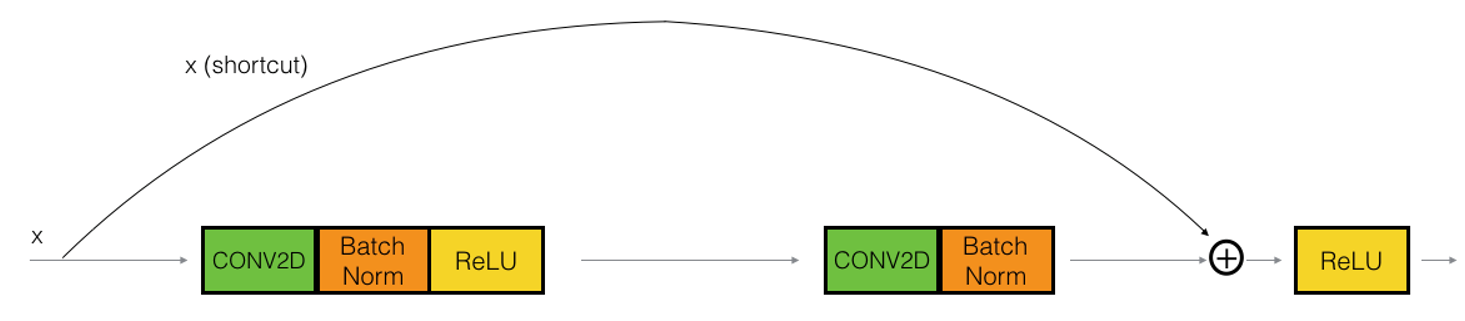
<caption><center> <u> <font color='purple'> <b>Figure 3</b> </u><font color='purple'>  : <b>Identity block.</b> Skip connection "skips over" 2 layers. </center></caption>

The upper path is the "shortcut path." The lower path is the "main path." In this diagram, notice the CONV2D and ReLU steps in each layer. To speed up training, a BatchNorm step has been added. 

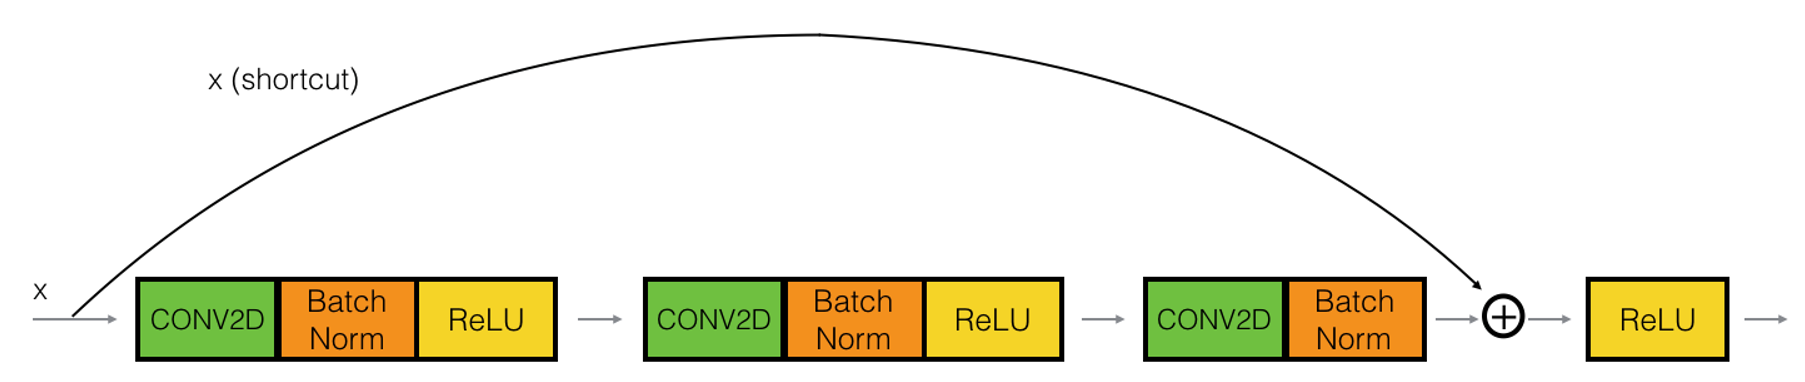
    <caption><center> <u> <font color='purple'> <b>Figure 4</b> </u><font color='purple'>  : <b>Identity block.</b> Skip connection "skips over" 3 layers.</center></caption>

In [4]:
# subclassing identity block
class IdentityBlock(Model):

    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    def __init__(self , filters , f , training=True, initializer=random_uniform): 
        super(IdentityBlock, self).__init__()
        self.filters = filters
        self.kernal_size = f
        self.training = training
        self.initializer = initializer
        F1,F2,F3 = self.filters
        
        self.conv1 = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = self.initializer(seed=0))
        self.bn1 = BatchNormalization(trainable = self.training)
        
        self.conv2 = Conv2D(filters = F2, kernel_size = self.kernal_size, strides = (1,1), padding = 'same', kernel_initializer = self.initializer(seed=0))
        self.bn2 = BatchNormalization(trainable = self.training)
        
        
        self.conv3 = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = self.initializer(seed=0))
        self.bn3 = BatchNormalization(trainable = self.training)
                
        self.act = Activation('relu') # because it has no parameter i can define only one
        self.add = tf.keras.layers.Add()
        
    def call(self , input_tensor):
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = self.act(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        
        x = self.add([input_tensor , x])
        x = self.act(x)
        
        return x 

In [6]:
#test
np.random.seed(1)
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3

X = np.concatenate((X1, X2, X3), axis = 0).astype(np.float32)

A3 = IdentityBlock(f=2, filters=[4, 4, 3],
                   initializer=lambda seed=0:constant(value=1),
                   training=False)
# aa = A3(X) # works
a = A3.call(X) # works
print('\033[1mWith training=False\033[0m\n')
print(a)

With training=False

tf.Tensor(
[[[[  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]]

  [[  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]]

  [[  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]]

  [[  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]
   [  0.         0.         0.      ]]]


 [[[192.71237  192.71237  192.71237 ]
   [192.71237  192.71237  192.71237 ]
   [192.71237  192.71237  192.71237 ]
   [ 96.85619   96.85619   96.85619 ]]

  [[192.71237  192.71237  192.71237 ]
   [192.71237  192.71237  192.71237 ]
   [192.71237  192.71237  192.71237 ]
   [ 96.85619   96.85619   96.85619 ]]

  [[192.71237  192.71237  192.71237 ]
   [

<a name='3-2'></a>
### 3.2 - The Convolutional Block

The ResNet "convolutional block" is the second block type. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path: 

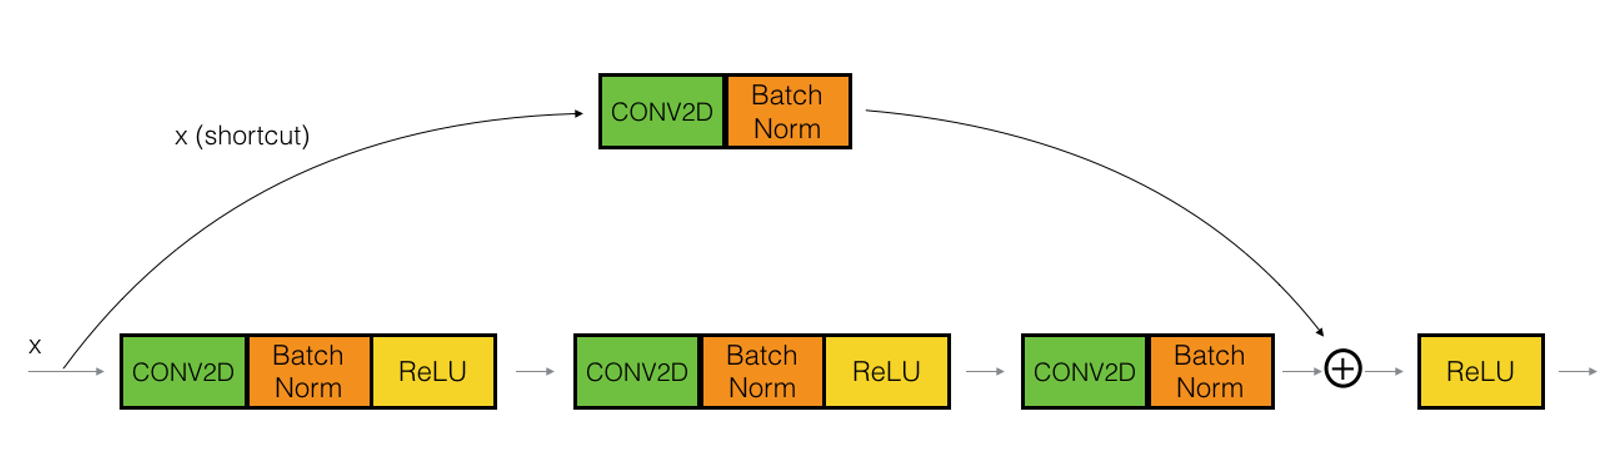
<caption><center> <u> <font color='purple'> <b>Figure 4</b> </u><font color='purple'>  : <b>Convolutional block</b> </center></caption>

* The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. 
* For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2. 
* The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step. 


The details of the convolutional block are as follows. 

First component of main path:
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid". Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The first BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape (f,f) and a stride of (1,1). Its padding is "same".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The second BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The third BatchNorm is normalizing the 'channels' axis. Note that there is no ReLU activation function in this component. 

Shortcut path:
- The CONV2D has $F_3$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The BatchNorm is normalizing the 'channels' axis. 

Final step: 
- The shortcut and the main path values are added together.
- Then apply the ReLU activation function. This has no hyperparameters. 
 

In [7]:
class ResConv_Block(Model):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    def __init__(self , filters , f , s = 2, training=True, initializer=glorot_uniform): 
        super(ResConv_Block, self).__init__()
    # Retrieve Filters
        self.filters = filters
        self.kernal_size = f
        self.training = training
        self.initializer = initializer
        F1,F2,F3 = self.filters
        self.s = s
        ##### MAIN PATH #####

        # First component of main path glorot_uniform(seed=0)
        self.conv1 = Conv2D(filters = F1, kernel_size = 1, strides = (self.s, self.s), padding='valid', kernel_initializer = self.initializer(seed=0))
        self.bn1 = BatchNormalization(trainable = self.training)


        ## Second component of main path 
        self.conv2 = Conv2D(filters = F2, kernel_size = self.kernal_size, strides = (1, 1), padding='same', kernel_initializer = self.initializer(seed=0))
        self.bn2 = BatchNormalization(trainable = self.training) 

        ## Third component of main path 
        self.conv3 = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = self.initializer(seed=0))
        self.bn3 = BatchNormalization(trainable = self.training) 

        ##### SHORTCUT PATH ##### 
        self.conv4 = Conv2D(filters = F3, kernel_size = 1, strides = (self.s, self.s), padding='valid', kernel_initializer = self.initializer(seed=0)) 
        self.bn4 = BatchNormalization(trainable = self.training)

       
        self.act = Activation('relu')
        self.add = tf.keras.layers.Add()
        
        # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    def call(self , input_tensor):
        x = self.conv1(input_tensor)
        
        x = self.bn1(x)
        
        x = self.act(x)
      
        x = self.conv2(x)
       
        x = self.bn2(x)
        x = self.act(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
    
        x_shortcut = self.conv4(input_tensor)
        x_shortcut = self.bn4(x_shortcut)
       
        x = self.add([x_shortcut , x])
        x = self.act(x)
        return x

In [8]:
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3

X = np.concatenate((X1, X2, X3), axis = 0).astype(np.float32)

A = ResConv_Block( f= 2 , filters = [2, 4, 6], training=True)
aa = A(X)
print(aa)

tf.Tensor(
[[[[1.6174058  0.         0.42508617 0.         0.6224668  0.04615028]
   [1.5492406  0.         0.27786672 0.         0.394169   0.        ]]

  [[1.6215826  0.         0.43410727 0.         0.6364561  0.05398379]
   [1.533513   0.         0.24389891 0.         0.34149408 0.        ]]]


 [[[0.         0.342508   0.         1.6461917  0.         0.16621608]
   [0.         0.342508   0.         1.6461917  0.         0.16621608]]

  [[0.         0.342508   0.         1.6461917  0.         0.16621608]
   [0.         0.32193616 0.         1.7424281  0.         0.19721802]]]


 [[[0.         1.0275239  0.         4.9385753  0.         0.49864823]
   [0.         1.0275239  0.         4.9385753  0.         0.49864823]]

  [[0.         1.0275239  0.         4.9385753  0.         0.49864823]
   [0.         0.9658084  0.         5.2272844  0.         0.591654  ]]]], shape=(3, 2, 2, 6), dtype=float32)


In [9]:
A.summary()

Model: "res_conv__block"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           multiple                  8         
                                                                 
 batch_normalization_6 (Batc  multiple                 8         
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           multiple                  36        
                                                                 
 batch_normalization_7 (Batc  multiple                 16        
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           multiple                  30        
                                                                 
 batch_normalization_8 (Batc  multiple             

<a name='4'></a>  
## 4 - Building Your First ResNet Model (50 layers)

You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

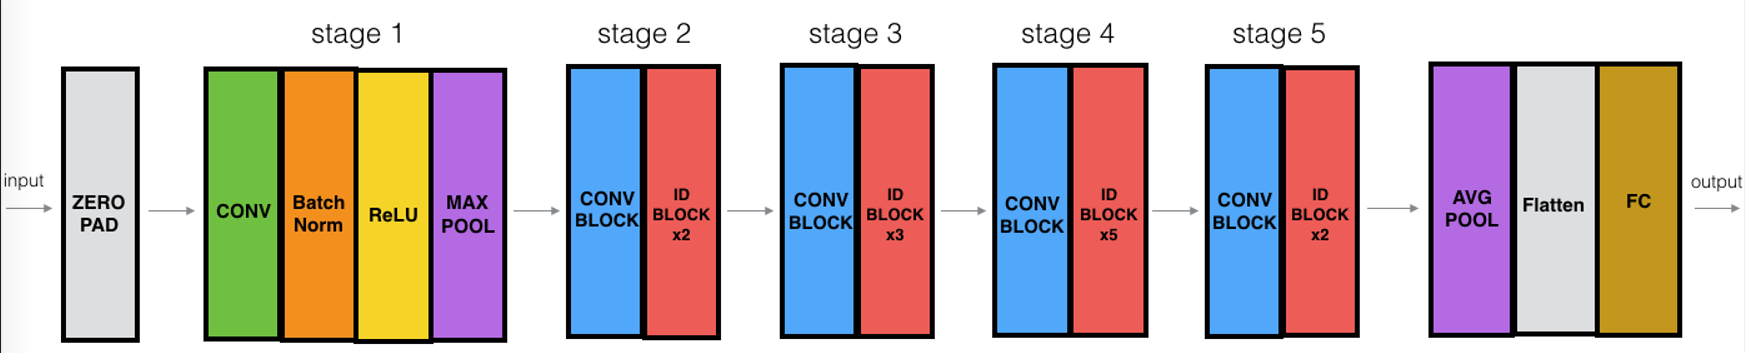
<caption><center> <u> <font color='purple'> <b>Figure 5</b> </u><font color='purple'>  : <b>ResNet-50 model</b> </center></caption>

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). 
    - BatchNorm is applied to the 'channels' axis of the input.
    - ReLU activation is applied.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, and "s" is 1.
    - The 2 identity blocks use three sets of filters of size [64,64,256], and "f" is 3.
- Stage 3:
    - The convolutional block uses three sets of filters of size [128,128,512], "f" is 3 and "s" is 2.
    - The 3 identity blocks use three sets of filters of size [128,128,512] and "f" is 3.
- Stage 4:
    - The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3 and "s" is 2.
    - The 5 identity blocks use three sets of filters of size [256, 256, 1024] and "f" is 3.
- Stage 5:
    - The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3 and "s" is 2.
    - The 2 identity blocks use three sets of filters of size [512, 512, 2048] and "f" is 3.
- The 2D Average Pooling uses a window of shape (2,2).
- The 'flatten' layer doesn't have any hyperparameters.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.

    
<a name='ex-3'></a>      
### Exercise 3 - ResNet50 
    


In [10]:
class ResNet50Model(Model):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    def __init__(self ,classes = 6):
        super(ResNet50Model , self).__init__()
        self.classes = classes
        
        # Zero-Padding
        self.zp = ZeroPadding2D((3, 3))
        
        # Stage 1
        self.conv1 = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))
        self.bn1= BatchNormalization(axis = 3)
        self.act = Activation('relu')
        self.mp1 = MaxPooling2D((3, 3), strides=(2, 2))

        # Stage 2
        self.ResConv1 = ResConv_Block( f = 3, filters = [64, 64, 256], s = 1)
        self.idbl1 = IdentityBlock(f = 3, filters =[64, 64, 256])
        self.idbl2 = IdentityBlock(f = 3, filters =[64, 64, 256])

    

        ## Stage 3 (≈4 lines)
        self.ResConv2 = ResConv_Block( f = 3, filters = [128, 128, 512], s = 2) 
        self.idbl3 = IdentityBlock(f =3, filters =[128, 128, 512]) 
        self.idbl4 = IdentityBlock(f = 3, filters =[128, 128, 512])
        self.idbl5 = IdentityBlock(f =3, filters =[128, 128, 512]) 

        ## Stage 4 (≈6 lines)
        self.ResConv3 = ResConv_Block( f = 3, filters = [256, 256, 1024], s = 2) 
        self.idbl6 = IdentityBlock(f = 3, filters =[256, 256, 1024]) 
        self.idbl7 = IdentityBlock(f = 3, filters =[256, 256, 1024])  
        self.idbl8 = IdentityBlock(f = 3, filters =[256, 256, 1024])  
        self.idbl9 = IdentityBlock(f = 3, filters =[256, 256, 1024])  
        self.idbl10 = IdentityBlock(f =3, filters =[256, 256, 1024])  

        ## Stage 5 (≈3 lines)
        self.ResConv4 = ResConv_Block( f = 3, filters = [512, 512, 2048], s = 2) 
        self.idbl11 = IdentityBlock(f = 3, filters =[512, 512, 2048])  
        self.idbl12 = IdentityBlock(f = 3, filters =[512, 512, 2048])  

        ## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
        self.avp = AveragePooling2D()

        ### END CODE HERE

        # output layer
        self.flatten = Flatten()
        self.dense = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))

    def call(self , input_tensor):
        
        x = self.zp(input_tensor)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.mp1(x)
        
        x = self.ResConv1(x)
        x = self.idbl1(x)
        x = self.idbl2(x)
        
        x = self.ResConv2(x)
        x = self.idbl3(x)
        x = self.idbl4(x)
        x = self.idbl5(x)
        
        x = self.ResConv3(x)
        x = self.idbl6(x)
        x = self.idbl7(x)
        x = self.idbl8(x)
        x = self.idbl9(x)
        x = self.idbl10(x)
        
        x = self.ResConv4(x)
        x = self.idbl11(x)
        x = self.idbl12(x)
        
        x = self.avp(x)
        x = self.flatten(x)
        x = self.dense(x)

        return x

In [11]:
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3

X = np.concatenate((X1, X2, X3), axis = 0).astype(np.float32)

A = ResNet50Model(1)
aa = A(X)
print(aa)

tf.Tensor(
[[1.]
 [1.]
 [1.]], shape=(3, 1), dtype=float32)


In [12]:
A.summary()

Model: "res_net50_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_10 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   multiple                  0         
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                   

In [13]:
my_model = ResNet50Model(6)

In [14]:
my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
from google.colab import files
uploaded = files.upload()

Saving train_signs.h5 to train_signs.h5


In [23]:
from google.colab import files
uploaded = files.upload()

Saving test_signs.h5 to test_signs.h5


> about the data : 
- we will use a signs for numbers from 0 to 5 but the task will be classification so each sign was encoded to vector 

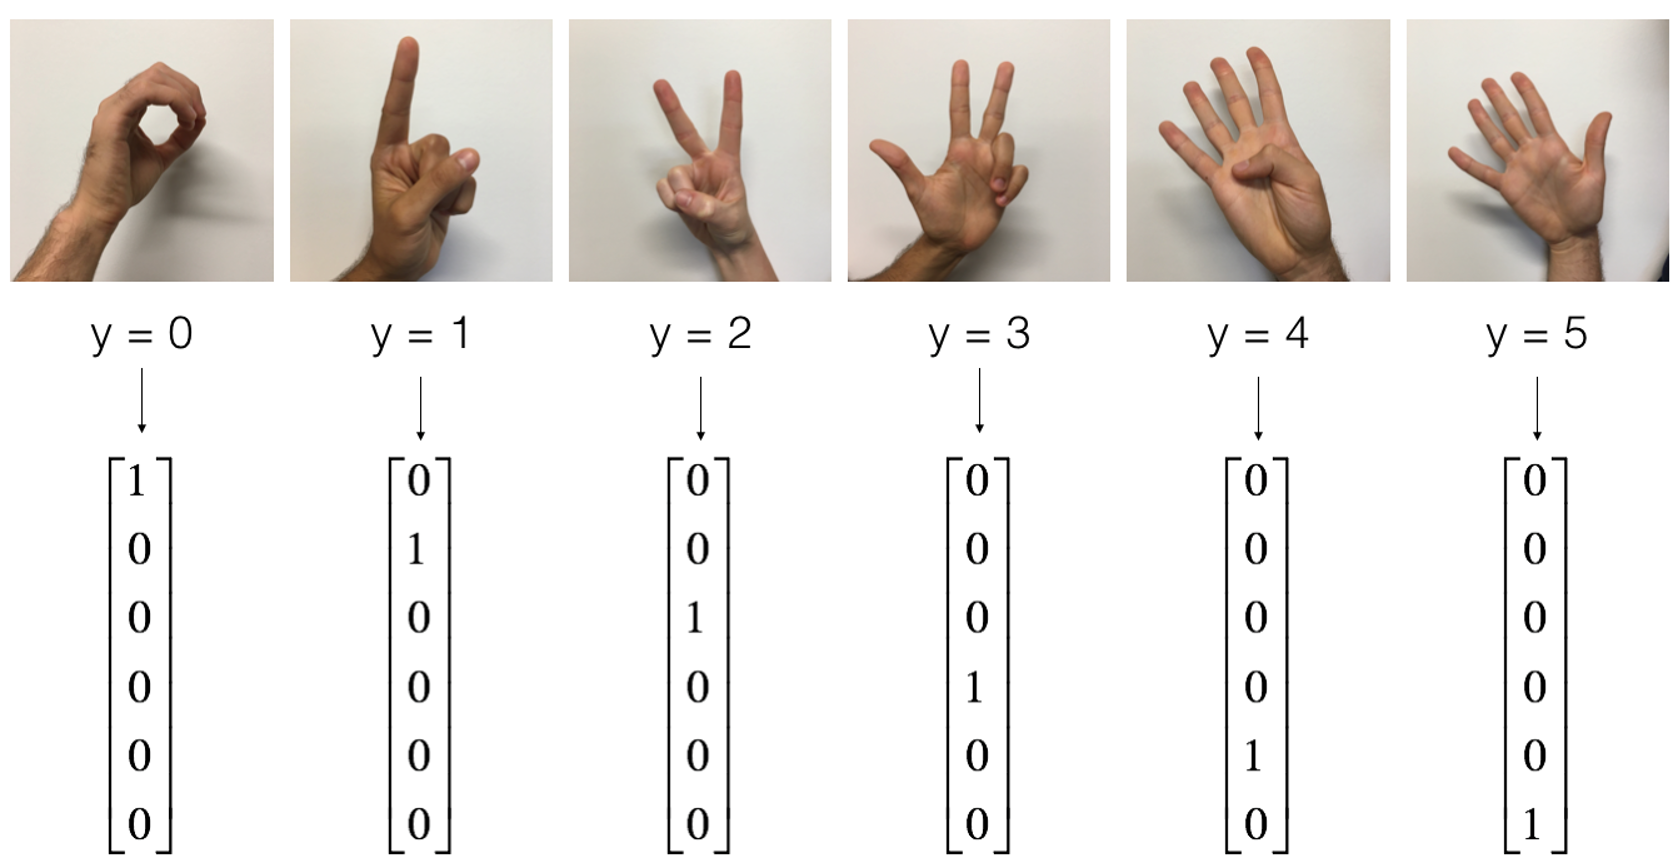

In [28]:
def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    # your train set features
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])

    '''
    img = Image.fromarray(train_set_x_orig[im])
    for im in range(len(train_set_x_orig)):
        img = Image.fromarray(train_set_x_orig[im])
        #img = ImageEnhance.Contrast(img).enhance(1)
        img = ImageOps.equalize(img, mask = None)
        img = img.filter(ImageFilter.SMOOTH)
        train_set_x_orig[im] = np.array(img)
    train_set_x_orig2 = []
    for im in range(len(train_set_x_orig)):
        train_set_x_orig2.append(np.rot90(train_set_x_orig[im], axes=(-3, -2)))
    train_set_x_orig3 = []
    for im in range(len(train_set_x_orig)):
        train_set_x_orig3.append(np.rot90(train_set_x_orig2[im], axes=(-3, -2)))
    train_set_x_orig3 = np.array(train_set_x_orig3)
    train_set_x_orig4 = []
    for im in range(len(train_set_x_orig)):
        train_set_x_orig4.append(np.rot90(train_set_x_orig3[im], axes=(-3, -2)))
    train_set_x_orig4 = np.array(train_set_x_orig4)

    train_set_x_orig = np.concatenate((train_set_x_orig, train_set_x_orig2, train_set_x_orig3, train_set_x_orig4))
    '''
    
    train_set_y_orig = np.array(
        train_dataset["train_set_y"][:])  # your train set labels

    #train_set_y_orig = np.concatenate((train_set_y_orig, train_set_y_orig, train_set_y_orig, train_set_y_orig))

    
    test_dataset = h5py.File('test_signs.h5', "r")
    # your test set features
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
        
    test_set_y_orig = np.array(
        test_dataset["test_set_y"][:])  # your test set labels

    classes = np.array(test_dataset["list_classes"][:])  # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [29]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [30]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [31]:
my_model.fit(X_train, Y_train, epochs = 10, batch_size = 32)

Epoch 1/10
34/34 [==============================] - 177s 5s/step - loss: 1.5422 - accuracy: 0.5231
Epoch 2/10
34/34 [==============================] - 170s 5s/step - loss: 0.6151 - accuracy: 0.7963
Epoch 3/10
34/34 [==============================] - 167s 5s/step - loss: 0.3031 - accuracy: 0.9046
Epoch 4/10
34/34 [==============================] - 170s 5s/step - loss: 0.2223 - accuracy: 0.9296
Epoch 5/10
34/34 [==============================] - 168s 5s/step - loss: 0.1141 - accuracy: 0.9620
Epoch 6/10
34/34 [==============================] - 167s 5s/step - loss: 0.1614 - accuracy: 0.9519
Epoch 7/10
34/34 [==============================] - 166s 5s/step - loss: 0.4666 - accuracy: 0.8806
Epoch 8/10
34/34 [==============================] - 168s 5s/step - loss: 0.4150 - accuracy: 0.8917
Epoch 9/10
34/34 [==============================] - 169s 5s/step - loss: 0.2000 - accuracy: 0.9296
Epoch 10/10
34/34 [==============================] - 170s 5s/step - loss: 0.0910 - accuracy: 0.9713


In [32]:
tf.saved_model.save(my_model, '/content/MyModel')

INFO:tensorflow:Assets written to: /content/MyModel/assets


In [33]:
import os
import zipfile
def zipdir(path, ziph):
# ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))
            
zipf = zipfile.ZipFile('./mymodel.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('/content/MyModel', zipf)
zipf.close()